In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 20 07:19:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 26.9 MB/s 


In [ ]:
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random



#Sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#matplot
import matplotlib.pyplot as plt


#embedding
from gensim.models import Word2Vec

# tqdm
from tqdm.notebook import tqdm

#tensorflow
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding, Flatten,Dense
from tensorflow import keras
import tensorflow_addons as tfa
from keras import backend as K

#os
import os



# Data-preprocessing

In [ ]:
train_file_path = "/content/drive/MyDrive/SML_assign/comp90051-22-s2-authorship/train.json"
test_file_path = "/content/drive/MyDrive/SML_assign/comp90051-22-s2-authorship/test.json"

with open(train_file_path, 'r') as f:
    data = json.load(f)
df_train = pd.DataFrame(data)

with open(test_file_path, 'r') as f:
    data = json.load(f)
df_test = pd.DataFrame(data)

In [ ]:
# author feature is used to retreive the corresponding labels and the coauthor feature is used for further training

# Retrieve the non-prolific author and prolific author index
non_prolific_author_index = []
prolific_author_index = []
for i,j in enumerate(df_train['authors']):
  sum = 0
  for k in j:
    if k < 100 and k >= 0:
      sum += 1
  if sum == 0:
    non_prolific_author_index.append(i)
  else:
    prolific_author_index.append(i)

df_non_prolifc_authors = df_train.drop(prolific_author_index)
df_prolific_authors = df_train.drop(non_prolific_author_index)


# create a new column for coauthor of prolific author dataframe
prolific_author_label = []
non_prolific_author_label = []
for i in df_prolific_authors['authors']:
  prolific_author_label_each_instance = []
  non_prolific_author_label_each_instance = []
  for j in i:
    if j >= 0 and j < 100:
      prolific_author_label_each_instance.append(j)
    else:
      non_prolific_author_label_each_instance.append(j)
  prolific_author_label.append(prolific_author_label_each_instance)
  non_prolific_author_label.append(non_prolific_author_label_each_instance)

#Creat a new column for futher training features

df_prolific_authors['coauthors'] = non_prolific_author_label

# get the corresponding percentage of non prolific author

selected_col_nums = 5000
non_prolific_author_rows = random.sample(range(18334),selected_col_nums)

df_selected_non_prolific_authors = df_non_prolifc_authors
df_selected_non_prolific_authors['coauthors'] = df_selected_non_prolific_authors.loc[:,'authors']


df_selected_data = pd.concat([df_selected_non_prolific_authors, df_prolific_authors,df_prolific_authors], axis = 0)

In [ ]:

df_selected_data


,authors,year,abstract,venue,title,coauthors
2,"[19166, 17763]",17,"[40, 1542, 1691, 2449, 1535, 2610, 1543, 1535,...",,"[2085, 1719, 1846, 1745, 2243, 1553, 1606, 159...","[19166, 17763]"
5,"[5396, 16841, 17598, 20375, 11436]",18,"[40, 1542, 1691, 3133, 33, 1923, 1650, 1642, 1...",4,"[46, 1617, 1667, 3979, 2073, 37, 53, 2080, 154...","[5396, 16841, 17598, 20375, 11436]"
6,"[4874, 20811]",14,"[37, 2067, 1681, 1866, 51, 1612, 43, 1545, 181...",0,"[34, 3646, 2073, 2035, 2346, 1886, 1543, 57, 1...","[4874, 20811]"
7,"[1398, 11095]",10,"[1664, 1575, 3781, 4692, 10, 1706, 1860, 2000,...",26,"[1615, 1966, 11, 3495, 1656, 4345, 24, 2353, 1...","[1398, 11095]"
8,"[12449, 20348]",18,"[46, 4822, 1692, 1553, 3591, 4914, 46, 2421, 6...",9,"[3591, 4914, 46, 2421, 1608, 37, 1740, 1825, 1...","[12449, 20348]"
...,...,...,...,...,...,...
25767,"[19974, 68, 8903]",1,"[40, 1542, 1691, 2449, 1535, 2855, 1549, 1755,...",23,"[1708, 33, 58, 57, 2174, 1548, 1538, 1553, 359...","[19974, 8903]"
25776,"[6353, 67, 3037, 15856, 13521]",10,"[40, 1542, 1691, 2907, 1540, 1535, 2121, 2431,...",10,"[53, 2555, 4480, 1535, 1637, 1898, 1549, 53, 3...","[6353, 3037, 15856, 13521]"
25778,"[7686, 3810, 87, 7451]",16,"[2144, 1661, 2151, 1966, 3776, 4864, 1546, 219...",31,"[1615, 1966, 11, 3238, 1653, 3318, 24, 2144, 1...","[7686, 3810, 7451]"
25781,"[14864, 92]",16,"[37, 1662, 33, 1814, 2036, 1692, 1553, 2333, 2...",0,"[46, 1670, 1826, 37, 1632, 46, 1991, 1525, 152...",[14864]


In [ ]:
# fill the empty string value of the title with -1 and plus one to avoid messing with the padding value


venue_list = []
for i in df_selected_data['venue']:
  if i == '':
    venue_list.append(-1)
  else:
    venue_list.append(i + 1)
  
df_selected_data = df_selected_data.drop(['venue'],axis = 1)
df_selected_data['venue'] =venue_list

print('number of void string of the venue',len(df_selected_data[df_selected_data['venue'] == -1].index.tolist()))

In [ ]:
#One-hot encoding the labels

total_label = []
for i in df_selected_data['authors']:
  label_each_instance = []
  for j in i:
    if j >= 0 and j < 100:
      label_each_instance.append(j)
  if len(label_each_instance) == 0:
    label_each_instance.append(100)
  total_label.append(label_each_instance)


multilable_binarizer = MultiLabelBinarizer()
ohe_prolific_labels = multilable_binarizer.fit_transform(total_label).astype('float')


In [ ]:
label_distribution = {}
for i in ohe_prolific_labels:
  for j in range(101):
    if i[j] == 1:
      label_distribution[j] = label_distribution.get(j, 0) + 1


label_distribution
keys = label_distribution.keys()
vals = label_distribution.values()

label_distribution_prob = np.array(list(vals))/np.sum(np.array(list(vals)))
total_number_instances = np.sum(np.array(list(vals)))
label_distribution = np.array(list(vals))
print(keys)
print(label_distribution)
print(label_distribution_prob)

plt.bar(keys, label_distribution_prob, label="Real distribution of labels")
plt.title('Labels distribution for the training data set')
plt.xlabel('The prolific author from 0 to 99')
plt.ylabel('Distribution of the labels')
plt.show()

plt.bar(keys, label_distribution, label="Number of labels")
plt.title('Labels for the training data set')
plt.xlabel('The prolific author from 0 to 99')
plt.ylabel('Number of labels')
plt.show()


# Word2Vec

In [ ]:
def convert_to_string(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(str(j))
    total_list.append(per_instance)
  return total_list


def convert_to_num(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(j)
    total_list.append(per_instance)
  return total_list

# word to vec title model
string_title = convert_to_string(df_train['title'])
# Word2Vec
model_title = Word2Vec(string_title, min_count=1)
print(model_title)











Word2Vec(vocab=3444, size=100, alpha=0.025)


In [ ]:
type(df_train['title'][0])

list

In [ ]:
# word to vec coauthor model
string_coauthor = convert_to_string(df_train['authors'])

model_coauthor = Word2Vec(string_coauthor, min_count=1)
print(model_coauthor)

Word2Vec(vocab=20433, size=100, alpha=0.025)


In [ ]:
# word to vec abstract model
string_abstract = convert_to_string(df_train['abstract'])
# Word2Vec

model_abstract = Word2Vec(string_abstract, min_count=1,workers=4)
print(model_abstract)

Word2Vec(vocab=4845, size=100, alpha=0.025)


In [ ]:
string_abstract = convert_to_string(df_train['abstract'])

In [ ]:
print(model_abstract.similarity('1', '2'))

0.34725717


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
model_abstract.wv['1']

array([ 0.9325655 ,  1.1048778 , -0.15912808,  0.16575037,  0.59627134,
        0.39444566,  0.15305175, -0.49195415, -1.828572  , -0.06493202,
        0.07254826,  0.4224136 , -0.80887705, -1.4045439 ,  0.6578873 ,
        0.24273317,  0.24299057, -1.0093166 ,  0.08629867, -0.47859758,
       -0.01759059, -0.5093286 ,  0.41642383,  0.18799575, -0.13638149,
       -0.0431513 , -0.25417936, -0.2425057 , -0.08023779, -0.7270764 ,
       -1.3128622 ,  0.6195528 ,  0.36813024,  0.32848597,  0.13390033,
        0.38901263,  0.75449455,  0.25247437, -0.15829611,  1.4501023 ,
       -0.5762748 , -0.3457888 ,  0.75169176, -0.02400872,  0.23553978,
       -0.29057682,  0.1539837 , -0.02277344,  0.10162782, -0.71708614,
       -0.22289154, -0.8955829 , -0.42532682, -0.06255367,  1.0788614 ,
        0.19098991,  0.16953976, -0.94783723, -0.6114193 , -0.18021299,
       -0.00433659, -0.294838  ,  0.7437635 ,  0.50315166, -0.5933357 ,
        0.8645253 , -0.5065468 , -0.09049308, -0.13299192,  0.79

In [ ]:
from gensim.models.keyedvectors import KeyedVectors








#Tensorflow


In [ ]:
def convert_to_string(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(str(j))
    total_list.append(per_instance)
  return total_list

# Handle the situation where the coauthor is zero
def convert_to_num(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(j)
    if len(per_instance) == 0:
      per_instance.append(21246)
    total_list.append(per_instance)
  return total_list

num_coauthor = convert_to_num(df_selected_data['coauthors'])
num_abstract = convert_to_num(df_selected_data['abstract'])
num_title = convert_to_num(df_selected_data['title'])

max_length_coauthor = max([len(i)for i in num_coauthor])
max_length_abstract = max([len(i)for i in num_abstract])
max_length_title = max([len(i)for i in num_title])
print('max_length_coauthor' ,max_length_coauthor)
print('max_length_abstract ',max_length_abstract)
print('max_length_title ', max_length_title)
print(min([len(i)for i in num_coauthor]))

max_length_coauthor 100
max_length_abstract  2804
max_length_title  102
1


In [ ]:
padded_coauthor = pad_sequences(num_coauthor,truncating = 'post',maxlen = 100,padding ='post')
padded_title = pad_sequences(num_title,truncating = 'post',maxlen = 32,padding ='post')
padded_abastract = pad_sequences(num_abstract,truncating = 'post',maxlen = 128,padding ='post')
# padded_venue = pad_sequences(df_selected_data['venue'],truncating = 'post',maxlen = 32,padding ='post')



df_real_train = pd.DataFrame({'coauthor':padded_coauthor.tolist(),'title':padded_title.tolist(),'abstract':padded_abastract.tolist(),'venue':df_selected_data['venue'].tolist()})

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df_real_train,ohe_prolific_labels,test_size=0.1,random_state=90051,shuffle = True)
X_train = [tf.convert_to_tensor(X_train['abstract'].to_list()),tf.convert_to_tensor(X_train['coauthor'].to_list()),tf.convert_to_tensor(X_train['title'].to_list()),tf.convert_to_tensor(X_train['venue'].to_list())]
X_test = [tf.convert_to_tensor(X_test['abstract'].to_list()),tf.convert_to_tensor(X_test['coauthor'].to_list()),tf.convert_to_tensor(X_test['title'].to_list()),tf.convert_to_tensor(X_test['venue'].to_list())]

In [ ]:
embedding_dimension = 128
vocabulary_size_title_abstract = 5000
vocabulary_size_coauthor = 21247
vocabulary_size_venue = 466

max_length_abstract = 128
max_length_title = 32
max_length_coauthor = 100
max_length_venue = 1

checkpoint_path = 'model/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create checkpoint callback
callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                              save_best_only=True,
                                              monitor = 'val_f1_score',
                                              mode='max')


inputs_abstract = keras.Input((max_length_abstract))
inputs_coauthor = keras.Input((max_length_coauthor))
inputs_title = keras.Input((max_length_title))
inputs_venue = keras.Input((max_length_venue))

abstract_embed_layer = layers.Embedding(input_dim = vocabulary_size_title_abstract, mask_zero=True, output_dim = embedding_dimension,input_length = max_length_abstract, embeddings_regularizer= tf.keras.regularizers.L2(0))(inputs_abstract)
average_pool1 = layers.GlobalAveragePooling1D()(abstract_embed_layer)

coauthor_embed_layer = layers.Embedding(input_dim = vocabulary_size_coauthor,mask_zero=True, output_dim = embedding_dimension,input_length = max_length_coauthor,embeddings_regularizer= tf.keras.regularizers.L2(0))(inputs_coauthor)
average_pool2 = layers.GlobalAveragePooling1D()(coauthor_embed_layer)

title_embed_layer = layers.Embedding(input_dim = vocabulary_size_title_abstract, mask_zero=True, output_dim = embedding_dimension,input_length = max_length_title, embeddings_regularizer= tf.keras.regularizers.L2(0))(inputs_title)
average_pool3 = layers.GlobalAveragePooling1D()(title_embed_layer)

venue_embed_layer = layers.Embedding(input_dim = vocabulary_size_venue, mask_zero=True, output_dim = embedding_dimension,input_length = max_length_venue,embeddings_regularizer= tf.keras.regularizers.L2(0))(inputs_venue)
average_pool4 = layers.GlobalAveragePooling1D()(venue_embed_layer)

concatenated_layer = layers.Concatenate(axis = 1)([average_pool1, average_pool2,average_pool3,average_pool4])
# average_pool = layers.GlobalAveragePooling1D()(concatenated_layer)
x0 = layers.Dense(512, activation="relu")(concatenated_layer)
d0 = layers.Dropout(0.3)(x0)
x1 = layers.Dense(256, activation="relu")(d0)
x2 = layers.Dropout(0.3)(x1)
x3 = layers.Dense(256, activation="relu") (x2)
x4 = layers.Dropout(0.3) (x3)
x5 = layers.Dense(101,activation="sigmoid") (x4)
model = keras.Model([inputs_abstract,inputs_coauthor,inputs_title,inputs_venue],x5)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                            

In [ ]:
# class_weight = {}
# for i in range(101):
#   class_weight[i] = 1
# class_weight[100] = 0.3



# metrics = tfa.metrics.F1Score(num_classes=100,threshold = 0.6, average='macro')
# metrics = tf.keras.metrics.CategoricalAccuracy()
METRICS = [
      # keras.metrics.Precision(name='precision'),
      # keras.metrics.Recall(name='recall'),
      tfa.metrics.F1Score(num_classes=101,threshold = 0.5, average='macro')
]




# loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2,from_logits=False)
# loss = tf.keras.losses.CategoricalCrossentropy()
loss = tf.keras.losses.BinaryCrossentropy()



optimizer = optimizers.Adam(learning_rate =0.001)
model.compile(loss= loss, optimizer= optimizer, metrics = METRICS)

# history = model.fit(X_train,y_train, epochs = 128, batch_size= 128,validation_data =(X_test,y_test),shuffle = True,class_weight = class_weight)


history = model.fit(X_train,y_train, epochs = 120, batch_size= 128,callbacks = [callback], validation_data = (X_test,y_test),shuffle = True)

Epoch 1/120
108/109 [============================>.] - ETA: 0s - loss: 0.1500 - f1_score: 0.0118
Epoch 1: val_f1_score improved from -inf to 0.00000, saving model to model/cp.ckpt
109/109 [==============================] - 2s 10ms/step - loss: 0.1497 - f1_score: 0.0118 - val_loss: 0.0642 - val_f1_score: 0.0000e+00
Epoch 2/120
105/109 [===========================>..] - ETA: 0s - loss: 0.0661 - f1_score: 0.0000e+00
Epoch 2: val_f1_score did not improve from 0.00000
109/109 [==============================] - 1s 6ms/step - loss: 0.0661 - f1_score: 0.0000e+00 - val_loss: 0.0635 - val_f1_score: 0.0000e+00
Epoch 3/120
102/109 [===========================>..] - ETA: 0s - loss: 0.0643 - f1_score: 0.0000e+00
Epoch 3: val_f1_score did not improve from 0.00000
109/109 [==============================] - 1s 6ms/step - loss: 0.0642 - f1_score: 0.0000e+00 - val_loss: 0.0616 - val_f1_score: 0.0000e+00
Epoch 4/120
101/109 [==========================>...] - ETA: 0s - loss: 0.0560 - f1_score: 0.0058
Epoch

In [ ]:
model.load_weights(checkpoint_path)


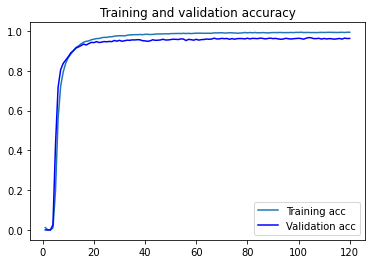

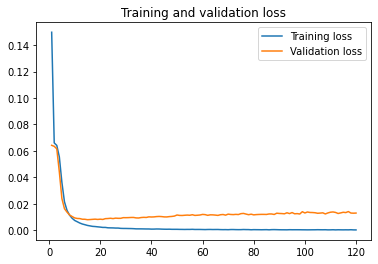

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss,  label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
y_pred = model.predict(X_test)

49/49 [==============================] - 0s 2ms/step


In [ ]:
y_test.shape

(1542, 101)

In [ ]:
score_list = []
for i,j in enumerate(np.linspace(0, 1, 21)):
  predicted_train = np.where(y_pred < j, 0, 1)
  a = f1_score(y_test, predicted_train, average='samples')
  score_list.append((round(i*0.05,3),a))

In [ ]:
score_list

[(0.0, 0.02360949683615485),
 (0.05, 0.9554208017883014),
 (0.1, 0.9563808863587475),
 (0.15, 0.9569969693678269),
 (0.2, 0.957149033413625),
 (0.25, 0.957149033413625),
 (0.3, 0.9572416774751407),
 (0.35, 0.9561608300907912),
 (0.4, 0.9557284911370515),
 (0.45, 0.9557284911370515),
 (0.5, 0.9558581928231734),
 (0.55, 0.9556420233463034),
 (0.6, 0.9545611759619542),
 (0.65, 0.9545611759619542),
 (0.7, 0.9545611759619542),
 (0.75, 0.9545611759619542),
 (0.8, 0.9536964980544747),
 (0.85, 0.9517128252079041),
 (0.9, 0.9515920881971465),
 (0.95, 0.9500987336968111),
 (1.0, 0.5583657587548638)]

In [ ]:
predicted_train = np.where(y_pred < 0.5, 0, 1)
predicted_train[6]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_test[6]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Test set

In [ ]:
test_num_coauthor = convert_to_num(df_test['coauthors'])
test_padded_coauthor = pad_sequences(test_num_coauthor,truncating = 'post',maxlen = 100,padding ='post')

test_num_abstract = convert_to_num(df_test['abstract'])
test_padded_abstract = pad_sequences(test_num_abstract,truncating = 'post',maxlen = 128,padding ='post')

test_num_title = convert_to_num(df_test['title'])
test_padded_title = pad_sequences(test_num_title,truncating = 'post',maxlen = 32,padding ='post')

venue_list = []
for i in df_test['venue']:
  if i == '':
    venue_list.append(-1)
  else:
    venue_list.append(i + 1)
  
df_test = df_test.drop(['venue'],axis = 1)
df_test['venue'] =venue_list

print('number of void string of the venue',len(df_test[df_test['venue'] == -1].index.tolist()))








number of void string of the venue 91


In [ ]:
#Prediction
y_pred = model.predict([test_padded_abstract,test_padded_coauthor,test_padded_title,df_test['venue']])
y_pred[1]

25/25 [==============================] - 0s 2ms/step


array([3.8578642e-21, 2.3824330e-11, 9.6771586e-01, 2.2289517e-10,
       1.6097251e-10, 2.8389080e-10, 3.3571187e-10, 7.4785407e-18,
       2.3690290e-15, 7.6722979e-16, 3.8140290e-11, 3.9426134e-14,
       8.7072502e-11, 2.1439122e-19, 7.5809138e-17, 4.3483413e-24,
       4.0995445e-25, 1.8468747e-15, 1.3423167e-12, 1.7023204e-18,
       8.0388829e-10, 1.3237478e-13, 2.8813665e-07, 3.4080746e-21,
       3.4191636e-13, 7.3726092e-16, 8.7949793e-11, 1.6377158e-05,
       2.1203278e-17, 3.1118559e-23, 3.2970368e-14, 2.8112481e-11,
       4.6062245e-15, 5.8281012e-07, 3.2604043e-21, 3.5257404e-14,
       9.5981995e-19, 8.1644128e-30, 9.9679440e-21, 1.7105228e-25,
       2.8012810e-19, 3.2590412e-18, 1.6560930e-19, 8.1741450e-13,
       3.7870684e-08, 2.6073979e-08, 3.6236477e-19, 1.1618038e-17,
       1.2199089e-15, 2.1935641e-06, 5.6191007e-11, 2.5092683e-21,
       2.9604716e-18, 1.3179951e-07, 8.2505097e-12, 2.5595663e-04,
       3.7420286e-26, 5.0700804e-21, 6.9444455e-12, 2.3022607e

In [ ]:
prediction = np.where(y_pred < 0.5, 0, 1)

In [ ]:
prediction[1].shape

(101,)

In [ ]:
predicted_list = [i.tolist() for i in prediction]
total_index_list = []
for i in predicted_list:
  index_list = []
  for j,k in enumerate(i):
    if k == 1:
      if j == 100:
        index_list.append('-1')
      else:
        index_list.append(str(j))
  if len(index_list) != 0:
    total_index_list.append(index_list)
  else:
    total_index_list.append([str(-1)])

predicted_str = []
for i in total_index_list:
  a = ','.join(i)
  predicted_str.append(a)

In [ ]:

df_output = pd.DataFrame({'ID': list(range(800)),'Predict':predicted_str})
df_output.to_csv('predicted_result.csv',index = False)

In [ ]:

df_output['Predict'].values.tolist().count('-1') / 800

0.3225

In [ ]:

df_output

,ID,Predict
0,0,92
1,1,2
2,2,31
3,3,23
4,4,"32,-1"
...,...,...
795,795,54
796,796,97
797,797,-1
798,798,"71,84"
